In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_singlegrid_quarter'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f4572852a90> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f45728495c0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.59 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.594    |
| time/              |          |
|    fps             | 106      |
|    iterations      | 1        |
|    time_elapsed    | 24       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 57 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.597       |
| time/                   |             |
|    fps                  | 248         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 45 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.613       |
| time/                   |             |
|    fps                  | 248         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008958871 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.785       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0713      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0256     |
|    std                  | 

policy iteration runtime: 41 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.639       |
| time/                   |             |
|    fps                  | 247         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009925622 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.85        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0345      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0258     |
|    std                  | 

policy iteration runtime: 40 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.654        |
| time/                   |              |
|    fps                  | 243          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0034764528 |
|    clip_fraction        | 0.344        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0396       |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0268      |
|    std

policy iteration runtime: 39 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.66        |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006545782 |
|    clip_fraction        | 0.347       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.883       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0379      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 42 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.669       |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006781551 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.888       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0703      |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0269     |
|    std                  |

policy iteration runtime: 41 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.673       |
| time/                   |             |
|    fps                  | 250         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004152441 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.905       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.065       |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0264     |
|    std                  |

policy iteration runtime: 40 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.677        |
| time/                   |              |
|    fps                  | 250          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068483264 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.899        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0354       |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.0276      |
|    std                  | 0.

policy iteration runtime: 51 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.678        |
| time/                   |              |
|    fps                  | 245          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0049222945 |
|    clip_fraction        | 0.353        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.912        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0741       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.0283      |
|    std                  | 0.

policy iteration runtime: 41 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.679        |
| time/                   |              |
|    fps                  | 253          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0029282123 |
|    clip_fraction        | 0.362        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.904        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0572       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.0276      |
|    std

policy iteration runtime: 40 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.678       |
| time/                   |             |
|    fps                  | 248         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008116079 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.905       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0452      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 41 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 248         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007416576 |
|    clip_fraction        | 0.37        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.914       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.043       |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.679        |
| time/                   |              |
|    fps                  | 249          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0044002025 |
|    clip_fraction        | 0.385        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.916        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0404       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.0296      |
|    std                  | 0.

policy iteration runtime: 39 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 248         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009569365 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.92        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0388      |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.028      |
|    std                  | 0.055       |
|    va

policy iteration runtime: 41 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.679        |
| time/                   |              |
|    fps                  | 246          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0079167755 |
|    clip_fraction        | 0.372        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.906        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0605       |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.0276      |
|    std                  | 0.

policy iteration runtime: 41 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.012622258 |
|    clip_fraction        | 0.374       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.917       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0448      |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.0287     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.681        |
| time/                   |              |
|    fps                  | 251          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0027329712 |
|    clip_fraction        | 0.379        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.915        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0535       |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.0274      |
|    std

policy iteration runtime: 36 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011001887 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.923       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0517      |
|    n_updates            | 2740        |
|    policy_gradient_loss | -0.0278     |
|    std                  |

policy iteration runtime: 39 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 236         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007660216 |
|    clip_fraction        | 0.388       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.922       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0599      |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.0293     |
|    std                  | 0.0549      |
|    va

<IPython.core.display.Javascript object>


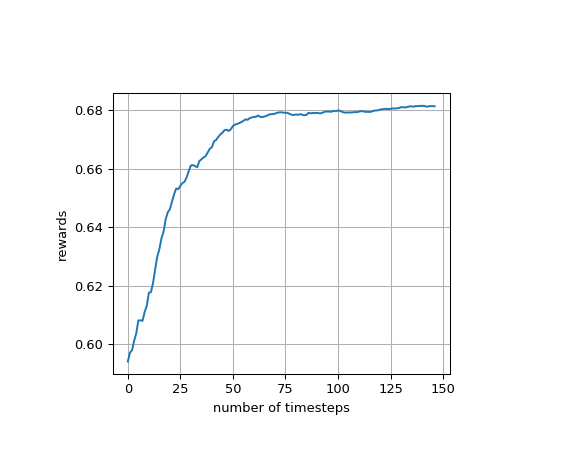

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f4572446908> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f45725dc588>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.601       |
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 1           |
|    time_elapsed         | 24          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006592798 |
|    clip_fraction        | 0.373       |
|    clip_range           | 0.1         |
|    entropy_loss         | 92          |
|    explained_variance   | 0.916       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.075       |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0274     |
|    std                  | 0.0549      |
|    value_loss           | 0.00289     |
------------

policy iteration runtime: 32 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.62       |
| time/                   |            |
|    fps                  | 231        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.01039381 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.799      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.049      |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0251    |
|    std                  | 0.055      |
|    v

policy iteration runtime: 39 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.641        |
| time/                   |              |
|    fps                  | 236          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070581674 |
|    clip_fraction        | 0.346        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.839        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0589       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0261      |
|    std 

policy iteration runtime: 38 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.659       |
| time/                   |             |
|    fps                  | 231         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007250157 |
|    clip_fraction        | 0.332       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.863       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.065       |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0254     |
|    std                  |

policy iteration runtime: 39 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.663       |
| time/                   |             |
|    fps                  | 237         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007168728 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.881       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0417      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0273     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 40 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.668       |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006884399 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.893       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.078       |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0265     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 31 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.671        |
| time/                   |              |
|    fps                  | 240          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0053995075 |
|    clip_fraction        | 0.342        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.898        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0741       |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0275      |
|    std

policy iteration runtime: 36 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.676        |
| time/                   |              |
|    fps                  | 238          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070462585 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.903        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0482       |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0281      |
|    std

policy iteration runtime: 28 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.678       |
| time/                   |             |
|    fps                  | 247         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005732241 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.911       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0493      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0282     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.678        |
| time/                   |              |
|    fps                  | 246          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0049013137 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.914        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0472       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.0265      |
|    std                  | 0.

policy iteration runtime: 40 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.678        |
| time/                   |              |
|    fps                  | 246          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0049883993 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.922        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0579       |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0282      |
|    std                  | 0.

policy iteration runtime: 32 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 247         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004576084 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.919       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0594      |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0278     |
|    std                  |

policy iteration runtime: 39 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.68         |
| time/                   |              |
|    fps                  | 247          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0073007615 |
|    clip_fraction        | 0.367        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.924        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0609       |
|    n_updates            | 1920         |
|    policy_gradient_loss | -0.0271      |
|    std                  | 0.

policy iteration runtime: 38 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009033928 |
|    clip_fraction        | 0.349       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.919       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0724      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0264     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 31 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.681        |
| time/                   |              |
|    fps                  | 245          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0054631024 |
|    clip_fraction        | 0.365        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.927        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0591       |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.0278      |
|    std                  | 0.

policy iteration runtime: 38 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007369903 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.924       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0631      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0286     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 247         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007288697 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.926       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0728      |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0258     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 31 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006635584 |
|    clip_fraction        | 0.391       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.932       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0421      |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0296     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 38 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.681        |
| time/                   |              |
|    fps                  | 239          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0048305006 |
|    clip_fraction        | 0.358        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.936        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0714       |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.0258      |
|    std

<IPython.core.display.Javascript object>


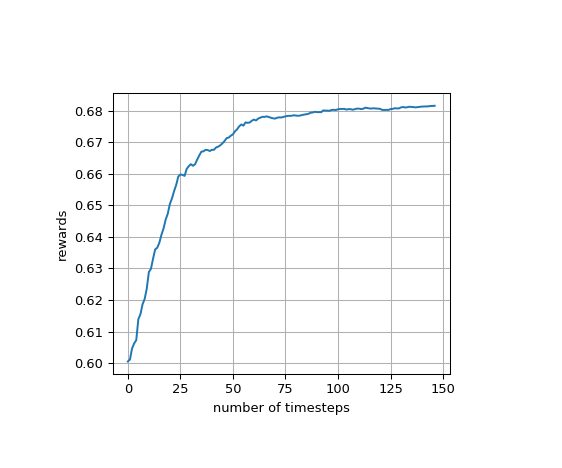

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f457244fef0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f4524280358>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.599       |
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1           |
|    time_elapsed         | 25          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006841746 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.932       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0593      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0269     |
|    std                  | 0.055       |
|    value_loss           | 0.00241     |
------------

policy iteration runtime: 40 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.616       |
| time/                   |             |
|    fps                  | 238         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011999324 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.79        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0322      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 

policy iteration runtime: 43 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.63         |
| time/                   |              |
|    fps                  | 241          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060845404 |
|    clip_fraction        | 0.333        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0552       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0245      |
|    std 

policy iteration runtime: 38 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.646       |
| time/                   |             |
|    fps                  | 239         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007718435 |
|    clip_fraction        | 0.342       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.876       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0752      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0253     |
|    std                  |

policy iteration runtime: 40 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
--------------------------------------------
| eval/                   |                |
|    mean_ep_length       | 5              |
|    mean_reward          | 0.659          |
| time/                   |                |
|    fps                  | 246            |
|    iterations           | 1              |
|    time_elapsed         | 10             |
|    total_timesteps      | 2560           |
| train/                  |                |
|    approx_kl            | -0.00017822385 |
|    clip_fraction        | 0.35           |
|    clip_range           | 0.1            |
|    entropy_loss         | 91.8           |
|    explained_variance   | 0.9            |
|    learning_rate        | 3e-06          |
|    loss                 | 0.0868         |
|    n_updates            | 640            |
|    policy_gra

policy iteration runtime: 52 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.666       |
| time/                   |             |
|    fps                  | 241         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011829317 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0601      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0271     |
|    std                  |

policy iteration runtime: 40 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.671        |
| time/                   |              |
|    fps                  | 244          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0061362833 |
|    clip_fraction        | 0.351        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.907        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0765       |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0268      |
|    std

policy iteration runtime: 49 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.674        |
| time/                   |              |
|    fps                  | 242          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0038417191 |
|    clip_fraction        | 0.365        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.916        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0619       |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0281      |
|    std                  | 0.

policy iteration runtime: 40 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.674       |
| time/                   |             |
|    fps                  | 241         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.002224502 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.918       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0532      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0287     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.676        |
| time/                   |              |
|    fps                  | 243          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0004625976 |
|    clip_fraction        | 0.359        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.922        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0475       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.0269      |
|    std

policy iteration runtime: 51 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.678        |
| time/                   |              |
|    fps                  | 240          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075011374 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.926        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0564       |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0282      |
|    std                  | 0.

policy iteration runtime: 42 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.678       |
| time/                   |             |
|    fps                  | 245         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008888384 |
|    clip_fraction        | 0.376       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.924       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0808      |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0291     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 39 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005399853 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.928       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0494      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0265     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 48 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.679        |
| time/                   |              |
|    fps                  | 247          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0052992105 |
|    clip_fraction        | 0.36         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.928        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0581       |
|    n_updates            | 2080         |
|    policy_gradient_loss | -0.0261      |
|    std

policy iteration runtime: 48 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 240         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006238499 |
|    clip_fraction        | 0.35        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.933       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0739      |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0274     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 42 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005147314 |
|    clip_fraction        | 0.354       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.928       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0403      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0262     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 39 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 239         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007890457 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.931       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0564      |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0289     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 40 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 235         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006664425 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.94        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0432      |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0262     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 39 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006715241 |
|    clip_fraction        | 0.378       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.937       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0366      |
|    n_updates            | 2880        |
|    policy_gradient_loss | -0.0276     |
|    std                  |

<IPython.core.display.Javascript object>


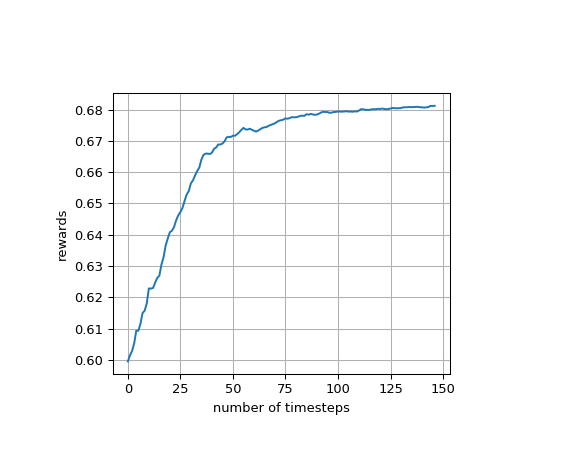

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.25],
                                episode_limit_array=[75000], 
                                log_dir=log_dir,
                                seed=seed)